<h2>Python R code analysis</h2>

<h4><u>Parsing and beautifing data</u></h4>

In [ ]:
# Install and load the necessary packages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import numpy as np
from statsmodels.robust.scale import mad
from FisherExact import fisher_exact
from matplotlib import ticker
from relis_types.Multivalue import Multivalue
from relis_types.Policies import Policies
from relis_types.Variable import Variable
from relis_types.DataFrame import DataFrame
from relis_types.NominalVariables import NominalVariables
from relis_types.NominalDataFrame import NominalDataFrame
from relis_types.ContinuousVariables import ContinuousVariables
from relis_types.ContinuousDataFrame import ContinuousDataFrame
from scipy.stats import kurtosis, skew, shapiro, spearmanr, pearsonr, chi2_contingency

Config

In [ ]:
custom = {"axes.edgecolor": "black", "grid.linestyle": "dashed", "grid.color": "grey"}
sns.set_style("darkgrid", rc = custom)

Utils

In [ ]:
def substituteNan(df: pd.DataFrame) -> None:
    df.replace(np.nan, '', inplace=True)

def get_variable(field_name: str, variables) -> Variable:
    return variables[field_name].value

def split_multiple_values(value):
    if not pd.isna(value):
        return [item.strip() for item in re.split(rf'\{Multivalue.SEPARATOR.value}', value)] 
    return [value]

def process_multiple_values(values: pd.Series, multiple: bool):
    if (multiple):
        return values.apply(lambda x: split_multiple_values(x))

    return values.apply(lambda x: [x])

def dataFrameGetTitle(statistic_type: str, statistic_name: str,
                          field_name: str, dependency_field_name = None):
    
    base_str =  f"{statistic_type} | {statistic_name} : {field_name}"

    if dependency_field_name: base_str += f"->{dependency_field_name}"

    return {'title': base_str}

def dataFrameUpdateTitle(dataFrame: pd.DataFrame, object: dict):
    dataFrame.attrs.update(object)

def display_data(dataFrame: pd.DataFrame | None, bool: bool):
    if type(dataFrame) != pd.DataFrame:
        print("No data... Nothing to show")
    elif bool:
        if dataFrame.attrs.get('title'): print(dataFrame.attrs.get('title'))
        print(dataFrame.to_markdown())
        print("\n")

def display_figure(plt, bool: bool):
    if bool: plt.show()

Parsing classification data

In [ ]:
project_classification_data = pd.read_csv('../data/relis_classification_CV.csv', encoding='utf8')

nominal_variables = {nominal_variable.value.title: nominal_variable.name for nominal_variable in NominalVariables}
continious_variables = {continious_variable.value.title: continious_variable.name for continious_variable in ContinuousVariables}

Preprocessing data for analysis 

In [ ]:
nominal_data = project_classification_data[nominal_variables.keys()].rename(columns=nominal_variables)
continuous_data = project_classification_data[continious_variables.keys()].rename(columns=continious_variables)

if (not Policies.DROP_NA.value):
    substituteNan(nominal_data)
    substituteNan(continuous_data)

nominal = NominalDataFrame(nominal_data, NominalVariables)
continuous = ContinuousDataFrame(continuous_data, ContinuousVariables)


<h4><u>DESCRIPTIVE STATS</u></h4>

In [ ]:
def beautify_data_desc(field_name: str, data: pd.DataFrame):
    # Get metadata
    variable = get_variable(field_name, NominalVariables)

    # Split the values by the "|" character and flatten the result
    split_values = process_multiple_values(data[field_name], variable.multiple)
    flattened_values = np.concatenate(split_values)

    # Generate the frequency table
    freq_table = pd.Series(flattened_values, dtype=str).value_counts().reset_index()
    freq_table.columns = ['value', 'n']

    # Calculate the percentage
    freq_table['percentage'] = (freq_table['n'] / freq_table['n'].sum()) * 100

    return freq_table

<h5 style="color:orange">Frequency tables<h5>

What do we do with the empty values ? Do they need to be part of the statistics calculation. <br>
Currently, I'll proceed by deleting them in the begining of the file

In [ ]:
def generate_desc_frequency_table(field_name: str, data: pd.DataFrame):
    return beautify_data_desc(field_name, data)

desc_frequency_tables = {NominalVariables[field_name]: generate_desc_frequency_table(field_name, nominal.data)
                      for field_name in nominal.data.columns}

print(desc_frequency_tables)

What do we do with the empty values ? Do they need to be part of the statistics calculation

<h5 style="color:orange">Bar Plots<h5>

In [ ]:
def generate_desc_bar_plot(field_name: str, data: pd.DataFrame):
    df = beautify_data_desc(field_name, data)

    if (len(df) == 0): return

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    hue = "n"
    sns.barplot(data=df, x="value", y="percentage", hue=hue, dodge=False)
    # Get metadata
    variable = get_variable(field_name, NominalVariables)

    # Set labels and title
    title = f"{variable.title} ~ Bar plot"
    plt.title(title)
    plt.xlabel(variable.title)
    plt.ylabel("Percentage")
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title=hue)
    plt.gca().get_legend().get_frame().set_edgecolor('black')

    return fig

desc_bar_plots = {NominalVariables[field_name]: generate_desc_bar_plot(field_name, nominal.data)
                    for field_name in nominal.data.columns}

print(desc_bar_plots)

<h5 style="color:orange">Statistics
<h5>

In [ ]:
def generate_desc_statistics(field_name: str, data: pd.DataFrame):
    series =  data[field_name]

    series.replace('', np.nan, inplace=True)

    if (len(data) == 0): return

    nan_policy = 'omit' if Policies.DROP_NA.value else 'propagate'
    results = {
    "vars": 1,
    "n": series.count(),
    "mean": series.mean(),
    "sd": series.std(),
    "median": series.median(),
    "trimmed": series[series.between(series.quantile(0.25), series.quantile(0.75))].mean(),
    "mad": mad(series),
    "min": series.min(),
    "max": series.max(),
    "range": series.max() - series.min(),
    "skew": skew(series, nan_policy=nan_policy),
    "kurtosis": kurtosis(series, nan_policy=nan_policy, fisher=True),
    "se": series.std() / np.sqrt(series.count())  
    }
    return results

desc_statistics = {ContinuousVariables[field_name]: generate_desc_statistics(field_name, continuous.data)
                      for field_name in continuous.data.columns}
print(desc_statistics)

<h5 style="color:orange">Box Plots<h5>

In [ ]:
def generate_desc_box_plot(field_name: str, data: pd.DataFrame):
    series = data[field_name]

    variable = get_variable(field_name, ContinuousVariables)

    # Create the box plot
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=series, color='lightblue', dodge=False)

    # Overlay the mean point
    mean_value = series.mean()
    plt.scatter(x=0, y=mean_value, color='red', s=50, zorder=3)  # s is the size of the point

    # Set the title and labels
    title = f"{variable.title} ~ Box plot"
    plt.title(title)
    plt.ylabel(variable.title)
    plt.xlabel('')

    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

    return fig

desc_box_plots = {ContinuousVariables[field_name]: generate_desc_box_plot(field_name, continuous.data)
                    for field_name in continuous.data.columns}

desc_box_plots[ContinuousVariables.publication_year].show()

<h5 style="color:orange">Violin Plots<h5>

In [ ]:
def generate_desc_violin_plot(field_name: str, data: pd.DataFrame):
    series = data[field_name]
    
    variable = get_variable(field_name, ContinuousVariables)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.violinplot(data=series, color="lightgray", dodge=False)

    plt.title(f"{variable.title} ~ Violin plot")
    plt.ylabel(variable.title)
    plt.xlabel("Density")
    plt.xticks([])

    return fig

desc_violin_plots = {ContinuousVariables[field_name]: generate_desc_violin_plot(field_name, continuous.data)
                       for field_name in continuous.data.columns}
print(desc_violin_plots)

<h4><u>EVOLUTIVE STATS</u></h4>

Is Publication.year a classfication field which is mandatory for each of the project ? <br>
It's currently hard coded and doesn't follow any patern.

In [ ]:
def beautify_data_evo(field_name: str, publication_year: pd.Series, variable: Variable, data: pd.DataFrame):
    series = data[field_name]
    
    # Create new DataFrame with specified columns
    subset_data = pd.DataFrame({
        'Year': publication_year,
        'Value': process_multiple_values(series, variable.multiple)
    })
    
    subset_data = subset_data.explode('Value')

    # Remove rows with empty values
    subset_data = subset_data[(subset_data['Value'] != '')]

    subset_data = subset_data.groupby(['Year', 'Value']).size().reset_index(name='Frequency')

    return subset_data

<h5 style="color:pink">Frequency tables<h5>

In [ ]:
def generate_evo_frequency_table(field_name: str, publication_year: pd.Series, data: pd.DataFrame):
    variable = get_variable(field_name, NominalVariables)

    subset_data = beautify_data_evo(field_name, publication_year, variable, data)

    # Pivoting the data
    subset_data = subset_data.pivot(index='Year', columns='Value', values='Frequency').fillna(0)

    subset_data.columns.name = None
    subset_data.reset_index(inplace=True)

    return subset_data 


evo_frequency_tables = {NominalVariables[field_name]: generate_evo_frequency_table(field_name, continuous.data["publication_year"], nominal.data)
                       for field_name in nominal.data.columns}

print(evo_frequency_tables)

<h5 style="color:pink">Evolution Plots<h5>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


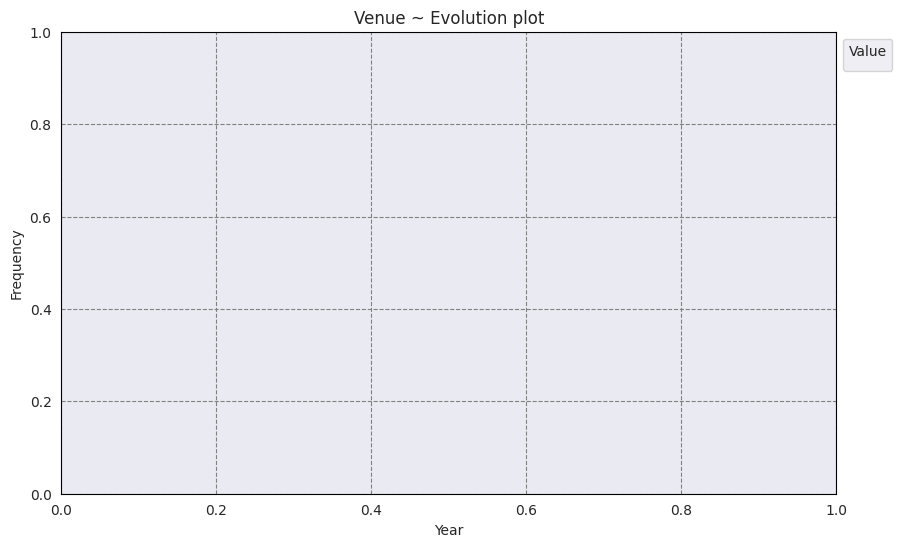

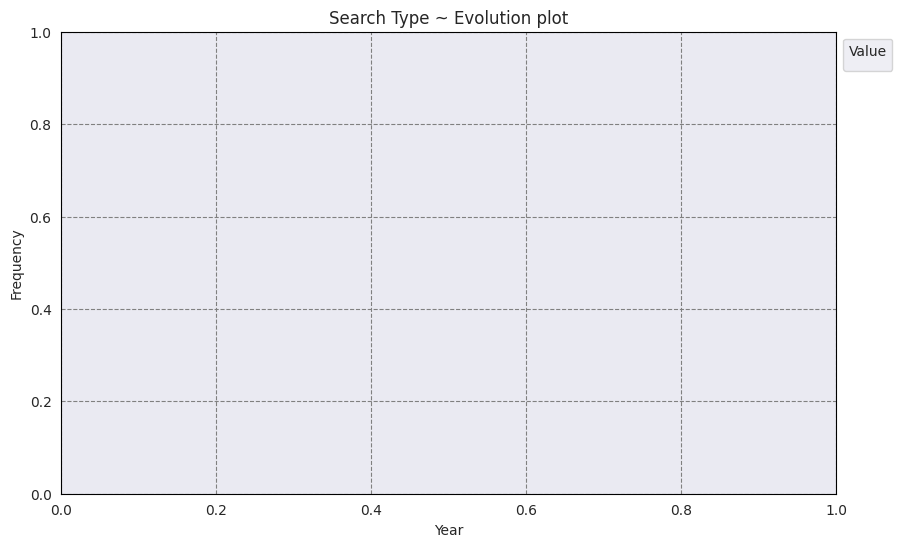

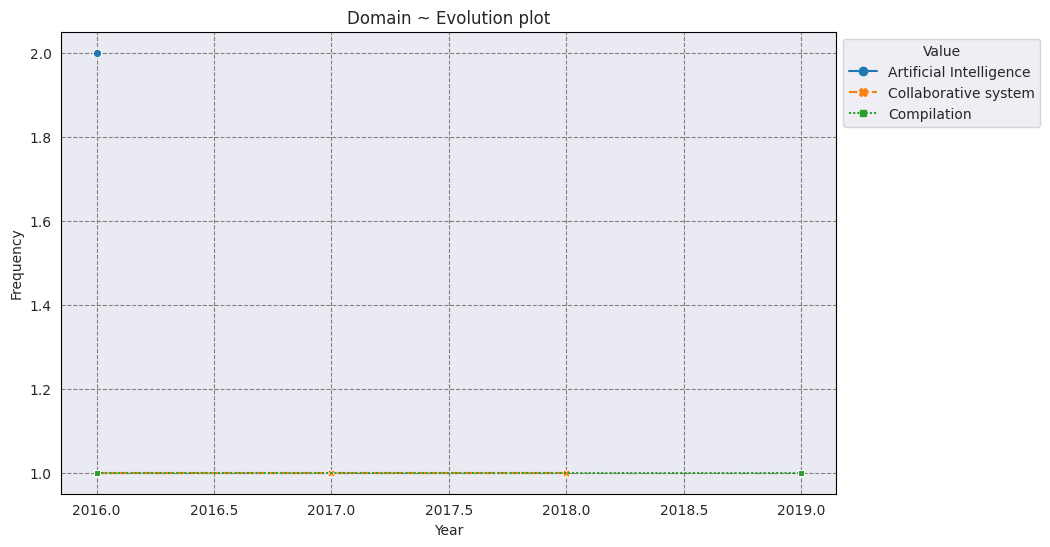

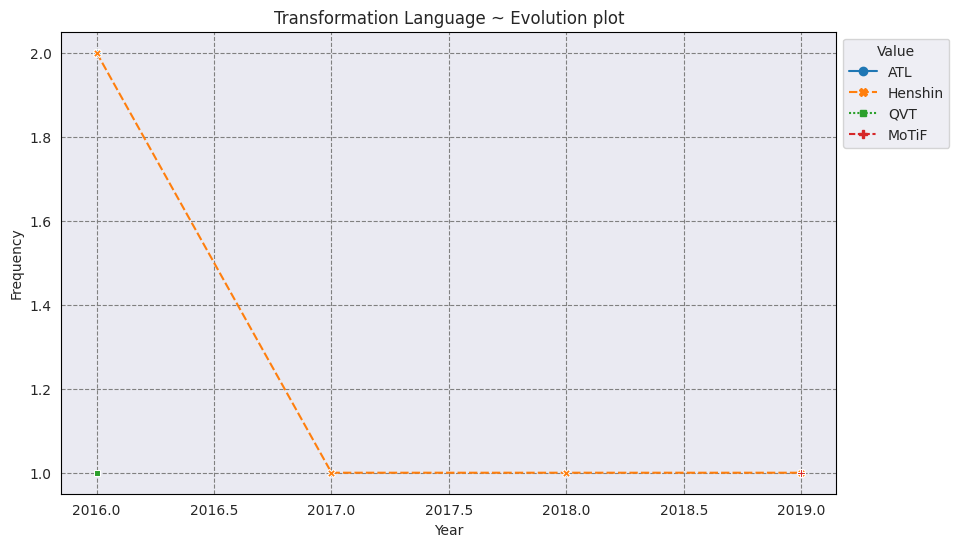

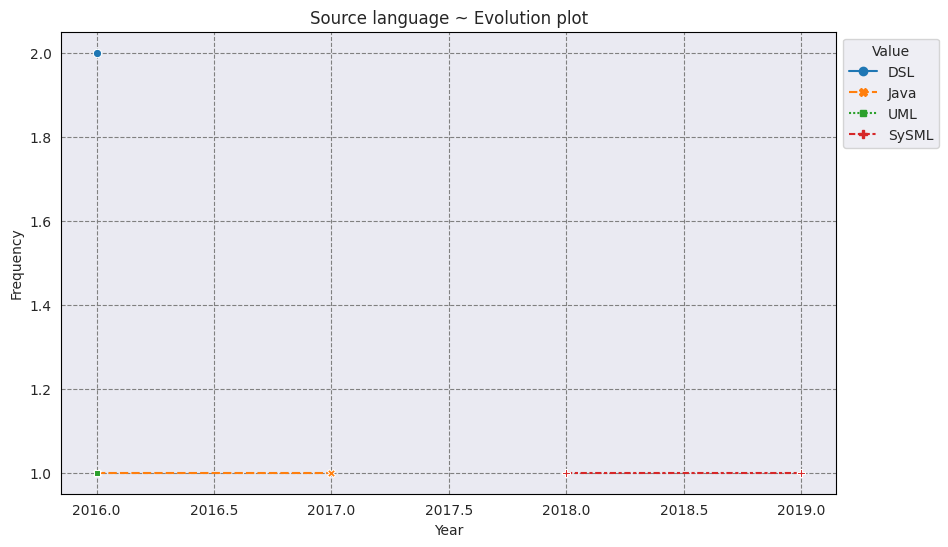

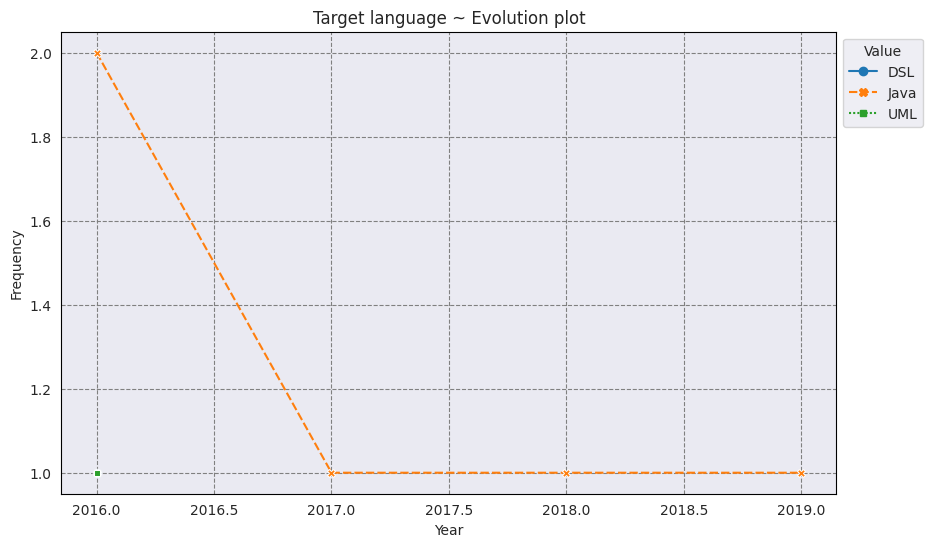

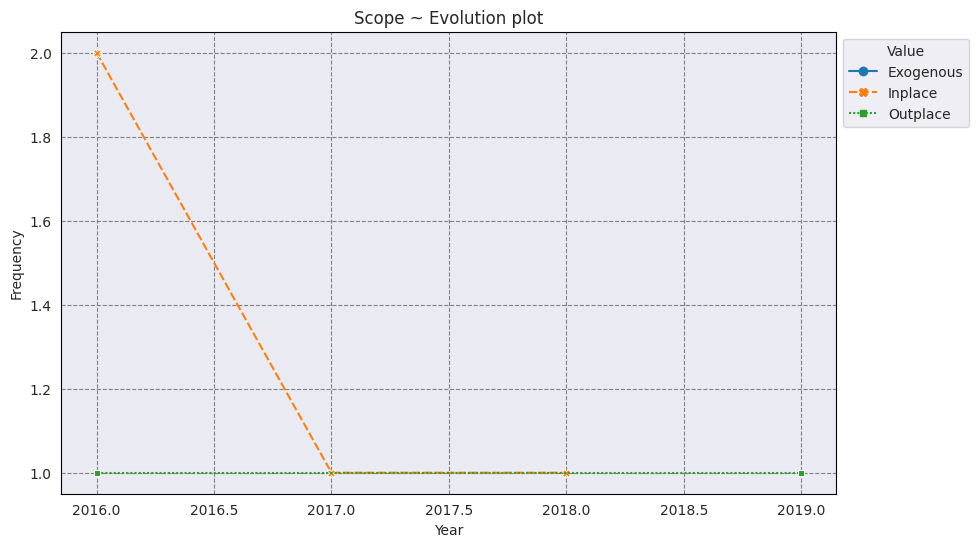

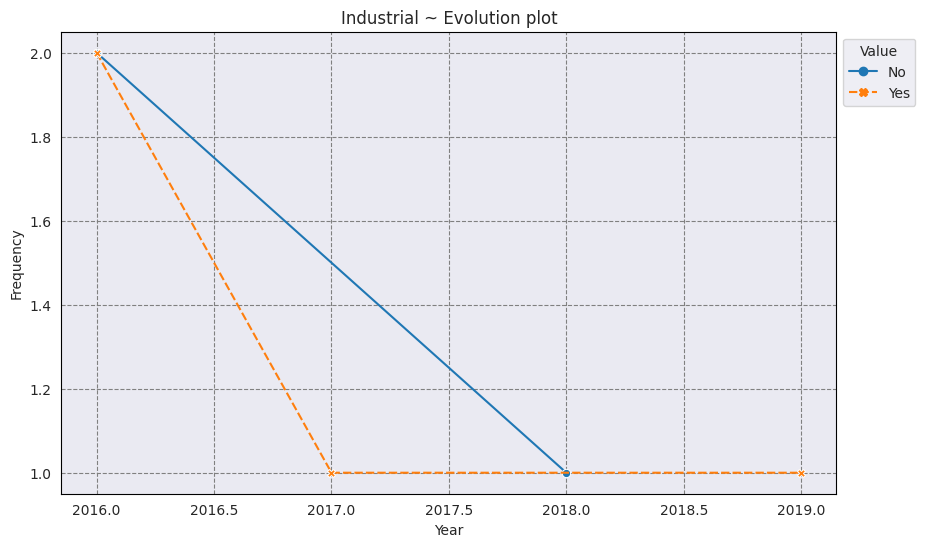

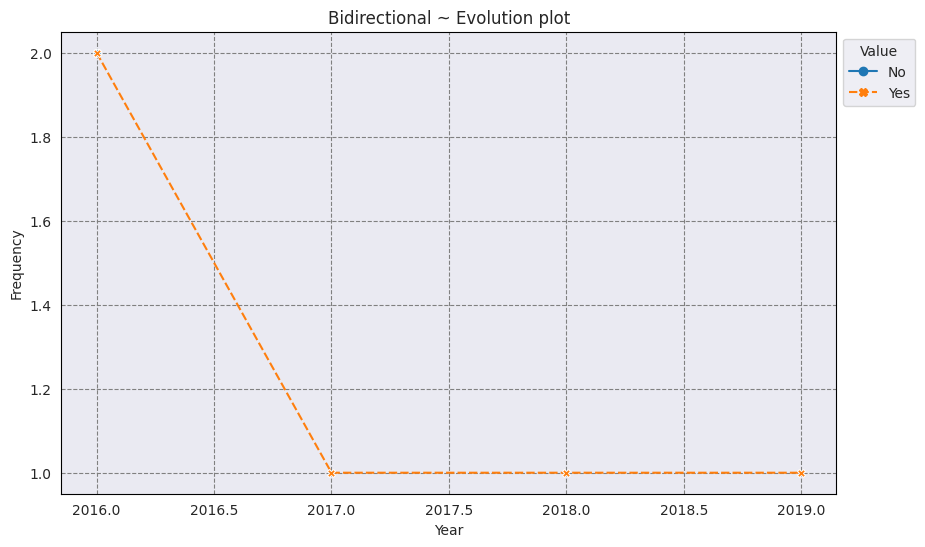

In [51]:
def generate_evo_plot(field_name: str, publication_year: pd.Series, data: pd.DataFrame):
    variable = get_variable(field_name, NominalVariables)
    
    subset_data = beautify_data_evo(field_name, publication_year, variable, data)

    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 6))
    hue = 'Value'
    sns.lineplot(data=subset_data, x='Year', y='Frequency', hue=hue, style='Value', markers=True)

    # Setting title, labels, and theme
    plt.title(f"{variable.title} ~ Evolution plot")
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.grid(True)
    handles, labels = ax.get_legend_handles_labels()

    if handles:
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title=hue)

    return fig

evo_plots = {NominalVariables[field_name]: generate_evo_plot(field_name, continuous.data["publication_year"], nominal.data)
                          for field_name in nominal.data.columns}


<h4><u>COMPARATIVE STATS</u></h4>

In [ ]:
def beautify_data_comp(field_name: str, dependency_field_name: str,
                        variable: Variable, dependency_variable: Variable, data: pd.DataFrame):    
    subset_data = pd.DataFrame({
        field_name: data[field_name],
        dependency_field_name: data[dependency_field_name]
    })
    
    # Filtering out rows where any of the variables is empty
    subset_data = subset_data[(subset_data[field_name] != "") & (subset_data[dependency_field_name] != "")]

    # Splitting the strings and expanding into separate rows
    subset_data[field_name] = process_multiple_values(subset_data[field_name], variable.multiple)
    subset_data = subset_data.explode(field_name)

    subset_data[dependency_field_name] = process_multiple_values(subset_data[dependency_field_name],
                                                                  dependency_variable.multiple)
    subset_data = subset_data.explode(dependency_field_name)

    # Counting occurrences
    subset_data = subset_data.groupby([field_name, dependency_field_name]).size().reset_index(name='Frequency')

    return subset_data

def evaluate_comparative_dependency_field(field_name: str, dataFrame: DataFrame, strategy):
    """
    Perform a statistical analysis strategy for each 
    dependency field of a given classification field.
    Act as a wrapper for the comparative statistical
    functions
    """
    field_names = list(dataFrame.data.columns)

    return {dataFrame.variable_type[dependency_field_name]: strategy(field_name, dependency_field_name, dataFrame.data)
             for dependency_field_name in field_names if dependency_field_name != field_name}

<h5 style="color:#98c377">Frequency Tables<h5>

In [ ]:
def generate_comp_frequency_table(field_name: str, dependency_field_name: str, data: pd.DataFrame):
    variable = get_variable(field_name, NominalVariables)
    dependency_variable = get_variable(dependency_field_name, NominalVariables)

    return beautify_data_comp(field_name, dependency_field_name,
                                      variable, dependency_variable, data)

comp_frequency_tables = {NominalVariables[field_name]: evaluate_comparative_dependency_field(field_name, nominal, generate_comp_frequency_table)
                       for field_name in nominal.data.columns}

print(comp_frequency_tables[NominalVariables.industrial][NominalVariables.domain])

<h5 style="color:#98c377">Bar Plots<h5>

In [ ]:
def generate_comp_stacked_bar_plot(field_name: str, dependency_field_name: str, data: pd.DataFrame):
    variable = get_variable(field_name, NominalVariables)
    dependency_variable = get_variable(dependency_field_name, NominalVariables)

    subset_data = beautify_data_comp(field_name, dependency_field_name,
                                      variable, dependency_variable, data)

    if subset_data.empty: return

    # Pivot the data to get a matrix form
    pivoted_data = subset_data.pivot(index=field_name, columns=dependency_field_name, values='Frequency')

    # Replace NaN values with 0
    pivoted_data = pivoted_data.fillna(0)

    fig, ax = plt.subplots(figsize=(10, 6))

    # Bottom value for stacking
    bottom_value = pd.Series([0] * pivoted_data.shape[0], index=pivoted_data.index)

    for col in pivoted_data.columns:
        plt.bar(pivoted_data.index, pivoted_data[col], bottom=bottom_value, label=col)
        bottom_value += pivoted_data[col]

    plt.title(f"{variable.title} and {dependency_variable.title} ~ Stacked bar plot")
    plt.xlabel(variable.title)
    plt.ylabel('Frequency')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title=dependency_field_name)

    return fig

comp_stacked_bar_plots = {NominalVariables[field_name]: evaluate_comparative_dependency_field(field_name, nominal, generate_comp_stacked_bar_plot)
                       for field_name in nominal.data.columns}
print(comp_stacked_bar_plots)

<h5 style="color:#98c377">Grouped Bar Plots<h5>

Only diverge from the stacked bar plot by the dodge attribute set to True

In [ ]:
def generate_comp_grouped_bar_plot(field_name: str, dependency_field_name: str, data: pd.DataFrame):
    variable = get_variable(field_name, NominalVariables)
    dependency_variable = get_variable(dependency_field_name, NominalVariables)

    subset_data = beautify_data_comp(field_name, dependency_field_name,
                                      variable, dependency_variable, data)

    if subset_data.empty: return

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=field_name, y='Frequency', hue=dependency_field_name, data=subset_data, dodge=True)

    plt.title(f"{variable.title} and {dependency_variable.title} ~ Grouped bar plot")
    plt.gca().set_xlabel('')
    plt.ylabel('Frequency')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title=dependency_field_name)
    
    return fig

comp_grouped_bar_plots = {NominalVariables[field_name]: evaluate_comparative_dependency_field(field_name, nominal, generate_comp_grouped_bar_plot)
                       for field_name in nominal.data.columns}
print(comp_grouped_bar_plots)

<h5 style="color:#98c377">Bubble Charts<h5>

Legend in the original script has more steps for the values (step value of 0.5)<br>
This type of figure will benefit from coloring the dots based on the frequency

In [ ]:
def generate_comp_bubble_chart(field_name: str, dependency_field_name: str, data: pd.DataFrame):
    variable = get_variable(field_name, NominalVariables)
    dependency_variable = get_variable(dependency_field_name, NominalVariables)

    subset_data = beautify_data_comp(field_name, dependency_field_name,
                                      variable, dependency_variable, data)

    if subset_data.empty: return

    # Creating the bubble chart
    fig, ax = plt.subplots(figsize=(10, 6))
    size = 'Frequency'
    sns.scatterplot(data=subset_data, x=field_name, y=dependency_field_name, size=size, color='black')

    # Adding labels and title
    plt.title(f"{variable.title} and {dependency_variable.title} ~ Bubble Chart")
    plt.gca().set_xlabel('')
    plt.gca().set_ylabel('')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title=size)

    return fig

comp_bubble_charts = {NominalVariables[field_name]: evaluate_comparative_dependency_field(field_name, nominal, generate_comp_bubble_chart)
                       for field_name in nominal.data.columns}
print(comp_bubble_charts)

<h5 style="color:#98c377">Fisher's Exact Test<h5>

The library used: https://github.com/maclandrol/FisherExact has an obsolete numpy dtype which causes the test to fail when the simulate_pval is set to True. An issue has been opened to let the devs know about the problem.

simulate_pval is mandatory to make the R results reproducdive in the python env.

To temporary fix the issue, the library should be pull from git and rebuild with the fix

1) change np.float to np.float32 in the fact = np.zeros(wkslimit + 1, dtype=np.float, order='F') assignation 
2) python3 setup.py install to build the library locally

In [ ]:
def generate_comp_chi_squared_test(field_name: str, dependency_field_name: str, data: pd.DataFrame):
    variable = get_variable(field_name, NominalVariables)
    dependency_variable = get_variable(dependency_field_name, NominalVariables)

    subset_data = beautify_data_comp(field_name, dependency_field_name,
                                      variable, dependency_variable, data)

    if subset_data.empty: return

    # Check for the condition where both variables are NaN
    if len(subset_data) == 1 and pd.isna(subset_data[field_name]).all() and pd.isna(subset_data[dependency_field_name]).all():
        return

    # Create contingency table
    contingency_table = pd.crosstab(subset_data[field_name], subset_data[dependency_field_name],
                                     values=subset_data['Frequency'], aggfunc='sum', dropna=False).fillna(0)
   
    # Calculating the Chi-squared statistic
    chi2_result = chi2_contingency(contingency_table)

    subset_data = pd.DataFrame({
        'p-value': chi2_result.pvalue # type: ignore
    }, index=[0])

    return subset_data

chi2_exact_test_vector = {NominalVariables[field_name]: evaluate_comparative_dependency_field(field_name, nominal, generate_comp_chi_squared_test)
                       for field_name in nominal.data.columns}

print(chi2_exact_test_vector)

<h5 style="color:#98c377">Shapiro Wilk's Correlation Test<h5>

In [ ]:
## Shapiro Wilk's Correlation Test

def generate_comp_shapiro_wilk_test(field_name: str, continuous_df: pd.DataFrame):
    subset_data = continuous_df[field_name].fillna(0)

    shapiro_result = shapiro(subset_data)

    return shapiro_result

comp_shapiro_wilk_tests = {ContinuousVariables[field_name]: generate_comp_shapiro_wilk_test(field_name, continuous.data)
                          for field_name in continuous.data.columns}
print(comp_shapiro_wilk_tests)

<h5 style="color:#98c377">Pearson's Correlation Test<h5>

In [ ]:
def generate_comp_pearson_cor_test(field_name: str, dependency_field_name: str, data: pd.DataFrame):
    _, pvalue = comp_shapiro_wilk_tests[ContinuousVariables[field_name]]
    _, dpvalue = comp_shapiro_wilk_tests[ContinuousVariables[dependency_field_name]]

    if not (pvalue > 0.05 and dpvalue > 0.05): return
    
    # Perform Pearson's correlation test
    pearson_coefficient, p_value = pearsonr(data[field_name].fillna(0), data[dependency_field_name].fillna(0))

    return pearson_coefficient, p_value

comp_pearson_cor_tests = {ContinuousVariables[field_name]: evaluate_comparative_dependency_field(field_name, continuous, generate_comp_pearson_cor_test)
                       for field_name in continuous.data.columns}

print(comp_pearson_cor_tests)

<h5 style="color:#98c377">Spearman's Correlation Test<h5>

In [ ]:
def generate_comp_spearman_cor_test(field_name: str, dependency_field_name: str, data: pd.DataFrame):
    _, pvalue = comp_shapiro_wilk_tests[ContinuousVariables[field_name]]
    _, dpvalue = comp_shapiro_wilk_tests[ContinuousVariables[dependency_field_name]]

    if  pvalue > 0.05 and dpvalue > 0.05: return
  
    # Perform Spearman's correlation test
    spearman_result = spearmanr(data[field_name].fillna(0), data[dependency_field_name].fillna(0))

    return spearman_result

comp_spearman_cor_tests = {ContinuousVariables[field_name]: evaluate_comparative_dependency_field(field_name, continuous, generate_comp_spearman_cor_test)
                       for field_name in continuous.data.columns}

print(comp_spearman_cor_tests)